# Setup

In [8]:
try:
  import geopandas as gpd
except ModuleNotFoundError as e:
  !pip install geopandas==0.10.0
  import geopandas as gpd
  if gpd.__version__ != "0.10.0":
    !pip install -U geopandas==0.10.0

---

# Exercise
1. load the shapefile of ISTAT with the information of the provinces
 - filter it for an italian provice at your choice (eg. Trento)
 - plot it
2. load the shapefile of ISTAT with the informations of the muncipalities
 - identify the cities of the province selected with the biggest and smallest area
 - extract all the centroids of the areas expressed in WGS84
 - select all the muncipalities of the Province of Trento
 - extract a representative point for the area of each municipality converted in WGS84<br/>suggestion: *.representative_point()*
 - save the points in a GeoJSON file
 - calculate the distance on the geodentic between the municipality with the big area and smallest area by using the centroid
3. download the shapefile of the [lakes and bodies of water](https://github.com/napo/geospatial_course_unitn/raw/master/data/trentino/lakes_bodies_of_water_trentino.zip) of Trentino
 - plot the geometries where Fktuso is “02”
 - convert in WGS84 and create a geojson
   
   note: projection Monte Mario zone 1


---

# Solutions

## learning objectives
* repeat the concepts on the previous lesson
* introduce geopackage
* centroid vs representative point

--- 

### Import of the packages

In [5]:
import geopandas as gpd
import pandas as pd
import os
import urllib
from matplotlib import pyplot as plt  #to avoid the warning message by plotting the geometries
import warnings
warnings.simplefilter("ignore")

## 1. load the shapefile of ISTAT with the information of the provinces

### This request is replaced with the use of geopackage

In the course material a geopackage file is available with all the shapefiles of the administrative limits of ISTAT (2022) with generalized geometries

[download](https://github.com/napo/geospatial_course_unitn/raw/master/data/istat/istat_administrative_units_2022.gpkg) the file *istat_administrative_units_generalized_2022.gpkg* from the repository from 
directory "data"

In [6]:
url = 'https://github.com/napo/geospatial_course_unitn/raw/master/data/istat/istat_administrative_units_generalized_2022.gpkg'

In [ ]:
urllib.request.urlretrieve(url ,"istat_administrative_units_generalized_2022.gpkg")

### Geopackage
![](https://www.ogc.org/pub/www/files/blog/Geopackage_layers.png)

[GeoPackage](http://opengeospatial.github.io/e-learning/geopackage/text/basic-index.html) is used for storing and accessing:
* Vector feature data
* Imagery tile matrix sets
* Raster map tile matrix sets
* non-spatial tabular data
* Metadata that describes other stored data

To have a look at the structure of the files, download the files and open them using the basic SQLite3 command-line utility.

```
sqlite3 istat_administrative_units_generalized_2022.gpkg
```
```
SQLite version 3.37.2 2022-01-06 13:25:41
Enter ".help" for usage hints.
sqlite>.table
```
```
gpkg_contents                     rtree_macroregions_geom_parent  
gpkg_extensions                   rtree_macroregions_geom_rowid   
gpkg_geometry_columns             rtree_municipalities_geom       
gpkg_metadata                     rtree_municipalities_geom_node  
gpkg_metadata_reference           rtree_municipalities_geom_parent
gpkg_ogr_contents                 rtree_municipalities_geom_rowid 
gpkg_spatial_ref_sys              rtree_provincies_geom           
gpkg_tile_matrix                  rtree_provincies_geom_node      
gpkg_tile_matrix_set              rtree_provincies_geom_parent    
macroregions                      rtree_provincies_geom_rowid     
municipalities                    rtree_regions_geom              
provincies                        rtree_regions_geom_node         
regions                           rtree_regions_geom_parent       
rtree_macroregions_geom           rtree_regions_geom_rowid        
rtree_macroregions_geom_node     
```
```
sqlite> .header on
```


```
sqlite> select * from macroregions;
```
```
fid|geom|COD_RIP|DEN_RIP|Shape_Leng|Shape_Area
1|GP|1|Nord-Ovest|2330182.61891|57929577720.9
2|GP|2|Nord-Est|2327764.9178|62385087837.3
3|GP|3|Centro|2010203.10916|58018645204.4
4|GP|4|Sud|2517096.68356|73777950167.2
5|GP|5|Isole|2775538.337|49917777679.9
```
```
sqlite> .q
```

Geopandas can manage geopackage by using [fiona](https://github.com/Toblerity/Fiona)

In [9]:
import fiona

In [10]:
fiona.supported_drivers

{'ARCGEN': 'r',
 'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'rw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'GPSTrackMaker': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}

```
'GPKG': 'raw',
```
**raw** => **r**ead **a**ppend **w**rite

geopandas can:
* **r**ead *geopackage* files
* **a**append data to a *geopackage* file
* **w**rite data to a *geopackage* file

geopackage can store more layers, so we have to investigate the contents

In [11]:
fiona.listlayers('istat_administrative_units_generalized_2022.gpkg')

['macroregions', 'regions', 'provincies', 'municipalities']

In [12]:
provincies = gpd.read_file("istat_administrative_units_generalized_2022.gpkg",layer="provincies")

*TIP*: you can also download the file directly from geopandas with this function

In [14]:
provincies = gpd.read_file(url,layer="provincies")

In [15]:
provincies.head(3)

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,DEN_PROV,DEN_CM,DEN_UTS,SIGLA,TIPO_UTS,Shape_Leng,Shape_Area,geometry
0,1,1,1,201,201,-,Torino,Torino,TO,Citta metropolitana,539249.811270,6.828137e+09,"MULTIPOLYGON (((411015.006 5049970.983, 411266..."
1,1,1,2,0,2,Vercelli,-,Vercelli,VC,Provincia,418078.067821,2.082097e+09,"MULTIPOLYGON (((438328.612 5087208.215, 439028..."
2,1,1,3,0,3,Novara,-,Novara,NO,Provincia,250242.030547,1.341318e+09,"MULTIPOLYGON (((460929.542 5076320.298, 461165..."


In [16]:
provincies.columns

Index(['COD_RIP', 'COD_REG', 'COD_PROV', 'COD_CM', 'COD_UTS', 'DEN_PROV',
       'DEN_CM', 'DEN_UTS', 'SIGLA', 'TIPO_UTS', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

**COD_RIP**<br/>
*codice ripartizione*<br/>
numeric code of the macroregion of belonging

**COD_REG**<br/>
*codice regione*<br/>
numeric code of the region of belonging

**COD_PROV**<br/>
*codice provincia*<br/>
numeric code of the region of belonging

**COD_CM**<br/>
*codice comune*<br/>
Istat code of the metropolitan city (three characters in
reference to all official statistics are
numeric format) obtained by adding the value 200 to
adopted the statistical codes of the cities
corresponding code of the province.

**COD_UTS**<br/>
*codice unità territoriali sovracomunali*<br/>
Numeric code that uniquely identifies the Units
territorial supra-municipal on the national territory.

**DEN_PROV**<br/>
*denominazione provincia*<br/>
name of the province

**DEN_CM**<br/>
*denominazione città metropolitana*<br/>
name of the metropolitan city

**DEN_UTS**<br/>
*denominazione unità territoriale sovracomunale*<br/>
Denomination of the supra-municipal territorial units.

**SIGLA**<br/>
*sigla*<br/>
abbreviation

**TIPO_UTS**<br/>
*tipologia unità territoriale sovracomunale*<br/>
kind of supra-municipal territorial units.



### filter it for an italian provice at your choice (eg. Trento)

obtain the list of all the provincies

In [17]:
provincies['DEN_PROV'].unique()

array(['-', 'Vercelli', 'Novara', 'Cuneo', 'Asti', 'Alessandria', 'Aosta',
       'Imperia', 'Savona', 'La Spezia', 'Varese', 'Como', 'Sondrio',
       'Bergamo', 'Brescia', 'Pavia', 'Cremona', 'Mantova', 'Bolzano',
       'Trento', 'Verona', 'Vicenza', 'Belluno', 'Treviso', 'Padova',
       'Rovigo', 'Udine', 'Gorizia', 'Trieste', 'Piacenza', 'Parma',
       "Reggio nell'Emilia", 'Modena', 'Ferrara', 'Ravenna',
       "Forli'-Cesena", 'Pesaro e Urbino', 'Ancona', 'Macerata',
       'Ascoli Piceno', 'Massa Carrara', 'Lucca', 'Pistoia', 'Livorno',
       'Pisa', 'Arezzo', 'Siena', 'Grosseto', 'Perugia', 'Terni',
       'Viterbo', 'Rieti', 'Latina', 'Frosinone', 'Caserta', 'Benevento',
       'Avellino', 'Salerno', "L'Aquila", 'Teramo', 'Pescara', 'Chieti',
       'Campobasso', 'Foggia', 'Taranto', 'Brindisi', 'Lecce', 'Potenza',
       'Matera', 'Cosenza', 'Catanzaro', 'Trapani', 'Agrigento',
       'Caltanissetta', 'Enna', 'Ragusa', 'Siracusa', 'Sassari', 'Nuoro',
       'Pordenone', '

obtain the list of all the metropolitan ciies

In [18]:
provincies.DEN_CM.unique()

array(['Torino', '-', 'Genova', 'Milano', 'Venezia', 'Bologna', 'Firenze',
       'Roma', 'Napoli', 'Bari', 'Reggio di Calabria', 'Palermo',
       'Messina', 'Catania', 'Cagliari'], dtype=object)

choose the province of Trento

In [20]:
province_of_trento = provincies[provincies['DEN_PROV']=='Trento']

In [21]:
province_of_trento

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,DEN_PROV,DEN_CM,DEN_UTS,SIGLA,TIPO_UTS,Shape_Leng,Shape_Area,geometry
21,2,4,22,0,22,Trento,-,Trento,TN,Provincia autonoma,594758.785501,6.208170e+09,"MULTIPOLYGON (((716676.337 5153931.623, 716029..."


### plot it

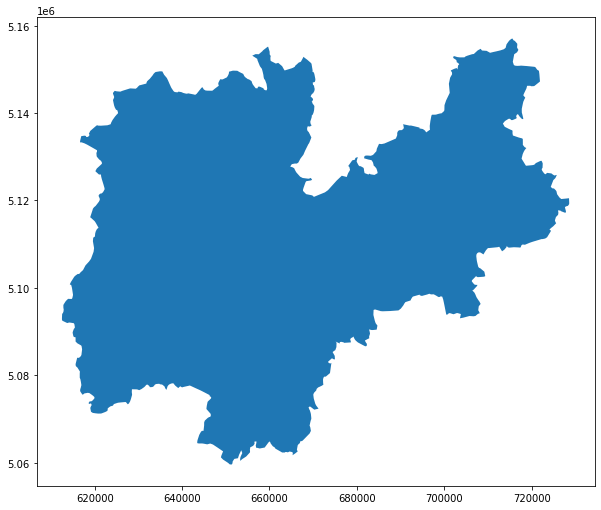

In [22]:
province_of_trento.plot(figsize=(10,10))
plt.show()

## 2. load the shapefile of ISTAT with the informations of the muncipalities
### identify the municipalities of the province selected with the biggest and smallest area

this means we need to use another layer / dataset

In [23]:
municipalities = gpd.read_file(url,layer="municipalities")

In [24]:
municipalities.columns

Index(['COD_RIP', 'COD_REG', 'COD_PROV', 'COD_CM', 'COD_UTS', 'PRO_COM',
       'PRO_COM_T', 'COMUNE', 'COMUNE_A', 'CC_UTS', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

**COD_RIP**<br/>
*codice ripartizione*<br/>
numeric code of the macroregion of belonging

**COD_REG**<br/>
*codice regione*<br/>
numeric code of the region of belonging

**COD_PROV**<br/>
*codice provincia*<br/>
numeric code of the region of belonging

**COD_CM**<br/>
*codice comune*<br/>
unique numeric identification code of the municipality within the province of belonging

**COD_UTS**<br/>
*codice unità territoriali sovracomunali*<br/>
Numeric code that uniquely identifies the Units
territorial supra-municipal on the national territory.

**PRO_COM**<br/>
*provincia comune**<br/>
Numeric code that uniquely identifies the Municipality
on the national territory. (= COD_PROV & COD_COM) 

**PRO_COM_T**<br/>
*provincia comune territorio**<br/>
Alphanumeric code that uniquely identifies the
Municipality on the national territory.<br/>
Like PRO_COM but definied in 6 fixed characters.

**COMUNE**<br/>
*comune*<br/>
Name of the Municipality

**COMUNE_A**<br/>
*comune alternativa*<br/>
Name of the Municipality in a language other than Italian

**CC_UTS**<br/>
*comune capoluogo*<br/>
Provincial capital or metropolitan city<br/>
1 => True<br/>
2 => False



the **COD_PROV** of the Province of Trento is **22**

In [25]:
# filter the province
municipalities_province_trento = municipalities[municipalities.COD_PROV==22]

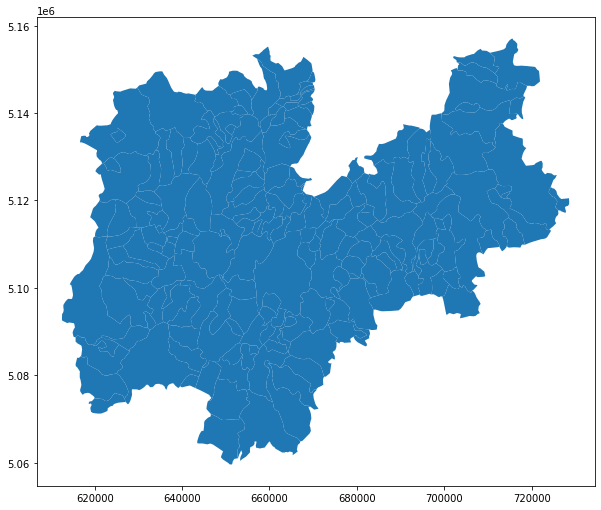

In [26]:
# plot it
municipalities_province_trento.plot(figsize=(10,10))
plt.show()

### identify the cities of the province selected with the biggest and smallest area

**CAUTION**:

we are using generalized boundaries !!!

finding the max area

In [27]:
max_area = municipalities_province_trento.geometry.area.max()

In [28]:
max_area

199625902.75494903

finding the min area

In [29]:
min_area = municipalities_province_trento.geometry.area.min()

In [30]:
min_area

1652100.49475859

... you can obtain the same in another way (combination of the requests)

In [31]:
municipalities[municipalities.COD_PROV==22].geometry.area.min()

1652100.49475859

### identify the municipality with the biggest area




In [32]:
maxarea_municipality_trentino = municipalities_province_trento[municipalities_province_trento.geometry.area == max_area]

In [33]:
maxarea_municipality_trentino.PRO_COM_T

3025    022245
Name: PRO_COM_T, dtype: object

In [34]:
maxarea_municipality_trentino.COMUNE

3025    Primiero San Martino di Castrozza
Name: COMUNE, dtype: object

the municipality with the bigger area is **Primiero San Martino di Castrozza** (022245)

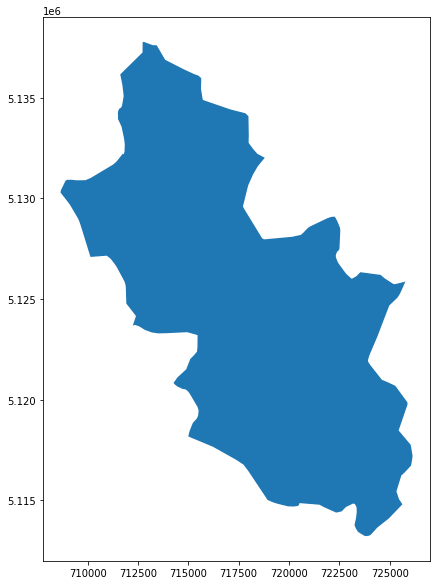

In [35]:
maxarea_municipality_trentino.plot(figsize=(10,10))
plt.show()

### identify the municipality with the smallest area


In [36]:
minarea_municipality_trentino = municipalities_province_trento[municipalities_province_trento.geometry.area == min_area]

In [37]:
minarea_municipality_trentino.COMUNE

2896    Carzano
Name: COMUNE, dtype: object

In [38]:
minarea_municipality_trentino.PRO_COM_T

2896    022043
Name: PRO_COM_T, dtype: object

the municipality with the smallest area is **Carzano** (022243)

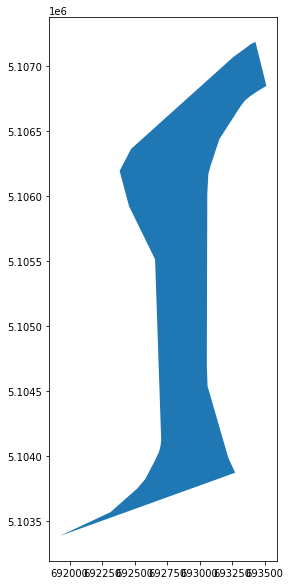

In [39]:
minarea_municipality_trentino.plot(figsize=(10,10))
plt.show()

### extract all the centroids of the areas expressed in WGS84

In [40]:
maxarea_municipality_trentino.geometry.centroid.to_crs(epsg=4326)

3025    POINT (11.82683 46.24190)
dtype: geometry

In [41]:
minarea_municipality_trentino.geometry.centroid.to_crs(epsg=4326)

2896    POINT (11.49436 46.07497)
dtype: geometry

### extract a rappresenative point for the area of the smallest and bigger municipality in WGS84

In [42]:
representative_point_minarea_municipality = minarea_municipality_trentino.geometry.representative_point()

In [43]:
representative_point_maxarea_municipality = maxarea_municipality_trentino.geometry.representative_point()

In [44]:
representative_point_minarea_municipality.to_crs(epsg=4326)

2896    POINT (11.49403 46.07235)
dtype: geometry

In [45]:
representative_point_maxarea_municipality.to_crs(epsg=4326)

3025    POINT (11.83795 46.24792)
dtype: geometry

### save the data in GeoJSON files

we can save each point in geojson 

In [46]:
representative_point_maxarea_municipality.to_crs(epsg=4326).to_file("point.geojson",driver="GeoJSON")

... but we need to create an only one file with all the data in a geojson file

In [47]:
points = representative_point_maxarea_municipality.append(representative_point_minarea_municipality)

In [48]:
points.to_crs(epsg=4326).to_file("points.geojson",driver="GeoJSON")

and we can do the same with the polygons

In [49]:
polygons = maxarea_municipality_trentino.append(minarea_municipality_trentino)

In [50]:
polygons.to_crs(epsg=4326).to_file("polygons.geojson",driver="GeoJSON")

In [51]:
# you need to use this function only if you are working with Google Colab
# uncomment if you want use it
# from google.colab import files
#files.download("points.geojson")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
#files.download("polygons.geojson")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**tip 1**:<br/>
you can download, open with [geojson.io](https://geojson.io) and create a [gist resource](https://gist.github.com/napo/b1d3b879bd0a93cbd3ae06be462bc873) to distribute

**tip 2**:<br/>
you can download the files and create a map with [umap](https://umap.openstretmap.fr) and create an [interactive map online with the data](http://umap.openstreetmap.fr/en/map/municipalities-of-the-province-of-trento_663616#11/46.1901/11.6750)

### calculate the distance on the geodentic between the municipality with the big area and smallest area by using the centroid


In [53]:
to_point = minarea_municipality_trentino.geometry.centroid.values[0]

In [54]:
maxarea_municipality_trentino.geometry.centroid.distance(to_point)

3025    31686.63797
dtype: float64

In [55]:
distance = maxarea_municipality_trentino.geometry.centroid.distance(to_point).values[0]

In [56]:
distance

31686.637969815347

the distance is in meters due the CRS used on the dataset 

In [57]:
to_city = minarea_municipality_trentino.COMUNE.values[0]
from_city = maxarea_municipality_trentino.COMUNE.values[0]
distance_km = distance/1000

In [58]:
print("the distance from %s to %s is %.1f km" % (from_city, to_city, round(distance_km,1)))

the distance from Primiero San Martino di Castrozza to Carzano is 31.7 km


### Why a representative point?

Where is the centroid of Liguria?


In [59]:
regions = gpd.read_file(url,layer="regions")

In [60]:
regions.DEN_REG.unique()

array(['Piemonte', "Valle d'Aosta", 'Lombardia', 'Trentino-Alto Adige',
       'Veneto', 'Friuli Venezia Giulia', 'Liguria', 'Emilia-Romagna',
       'Toscana', 'Umbria', 'Marche', 'Lazio', 'Abruzzo', 'Molise',
       'Campania', 'Puglia', 'Basilicata', 'Calabria', 'Sicilia',
       'Sardegna'], dtype=object)

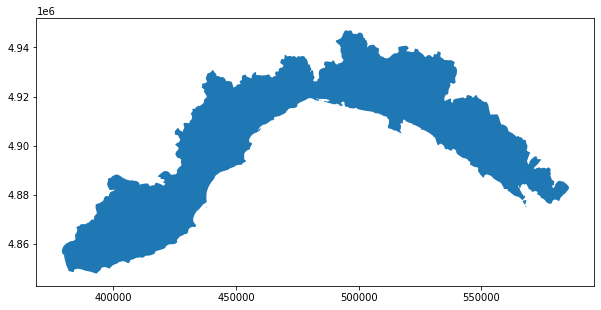

In [61]:
regions[regions.DEN_REG=='Liguria'].plot(figsize=(10,10))
plt.show()

In [62]:
regions[regions.DEN_REG=='Liguria'].to_crs(epsg=4326).to_file("liguria.geojson",driver='GeoJSON')

In [63]:
regions[regions.DEN_REG=='Liguria'].centroid.to_crs(epsg=4326).to_file("liguria_centroid.geojson",driver='GeoJSON')

In [64]:
regions[regions.DEN_REG=='Liguria'].representative_point().to_crs(epsg=4326).to_file("liguria_representative_point.geojson",driver='GeoJSON')

In [66]:
# uncomment if you want download from Colab
# files.download("liguria.geojson")

In [67]:
# uncomment if you want download from Colab
# files.download("liguria_centroid.geojson")

In [65]:
# uncomment if you want download from Colab
# files.download('liguria_representative_point.geojson')

you can upload all the geojson on [uMap](http://umap.openstreetmap.fr) to [see the result](http://umap.openstreetmap.fr/it/map/liguria_505528#8/44.058/9.075) 

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/umap_liguria.jpg)


## 3. download the shapefile of the [lakes and bodies of water](https://github.com/napo/geospatial_course_unitn/raw/master/data/trentino/lakes_bodies_of_water_trentino.zip) of Trentino
note: the shapefile is in Monte Mario 1

In [68]:
dataurl='https://github.com/napo/geospatial_course_unitn/raw/master/data/trentino/lakes_bodies_of_water_trentino.zip'
lakes_bodies_of_water_trentino = gpd.read_file(dataurl)

###  plot the geometries where Fktuso is “02”

In [69]:
lakes_bodies_of_water_trentino.head(3)

,OBJECTID,NOMESPACQ,geometry
0,29690.0,LAGO DI MOLVENO,"POLYGON ((1652079.952 5111676.932, 1652079.586..."
1,29743.0,LAGO BACINO S.I.T. - BACINO DI PONTARSO,"POLYGON ((1692832.012 5109957.392, 1692832.114..."
2,29723.0,LAGO DEL CARESER,"POLYGON ((1630312.511 5142839.286, 1630311.588..."


In [70]:
lakes_bodies_of_water_trentino.columns

Index(['OBJECTID', 'NOMESPACQ', 'geometry'], dtype='object')

where is "*Fktuso*" ???

*We have to analyze the ESRI Shapefile*

In [71]:
os.mkdir("shapefile")

In [72]:
os.chdir("shapefile")

In [73]:
urllib.request.urlretrieve(dataurl ,"lakes_bodies_of_water_trentino.zip")


('lakes_bodies_of_water_trentino.zip',
 <http.client.HTTPMessage at 0x7f5dcf5444d0>)

In [74]:
import zipfile
z = zipfile.ZipFile('lakes_bodies_of_water_trentino.zip')
z.extractall()

In [75]:
os.listdir()

['lakes_bodies_of_water_trentino_use.dbf',
 'lakes_bodies_of_water_trentino.shx',
 'lakes_bodies_of_water_trentino.zip',
 'lakes_bodies_of_water_trentino.dbf',
 'lakes_bodies_of_water_trentino.shp']

| filenname | description  | note |
|---|---|---|
| lakes_bodies_of_water_trentino.shp | the file with the shapes (geometries) | ok |
| lakes_bodies_of_water_trentino_use.dbf  | the file with the attributes | the name is NOT the same of the .shp |
|  lakes_bodies_of_water_trentino.dbf | the file with the attributes  | the name is the same of the .shp |
| lakes_bodies_of_water_trentino.zip  | the zip archive | it's present because downloaded | 
| lakes_bodies_of_water_trentino.shx  | the file to associate the attributes to the geometries | the name is the the of the .shp |

How we can use the file *lakes_bodies_of_water_trentino_use.dbf*?

Try to create a shapefile from the other

In [76]:
from shutil import copyfile

In [77]:
copyfile("lakes_bodies_of_water_trentino.shp","lakes_bodies_of_water_trentino_use.shp")

'lakes_bodies_of_water_trentino_use.shp'

In [78]:
copyfile("lakes_bodies_of_water_trentino.shx","lakes_bodies_of_water_trentino_use.shx")

'lakes_bodies_of_water_trentino_use.shx'

In [79]:
lakes_bodies_of_water_trentino_use =  gpd.read_file("lakes_bodies_of_water_trentino_use.shp")

In [80]:
lakes_bodies_of_water_trentino_use.columns

Index(['FKTUSO', 'geometry'], dtype='object')

there is the attribute "FTKUSO" ... 

In [81]:
lakes_bodies_of_water_trentino_use.FKTUSO.unique()

array(['0101', '92', '0191', '0192', '02', '0102'], dtype=object)

... and there is also the value "02"

In [82]:
ftkuso02 = lakes_bodies_of_water_trentino_use[lakes_bodies_of_water_trentino_use.FKTUSO=='02']

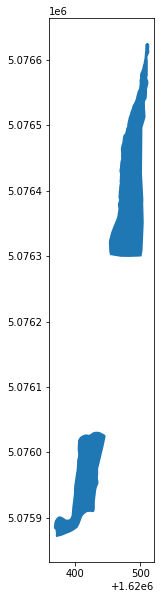

In [83]:
ftkuso02.plot(figsize=(10,10))
plt.show()

### convert in WGS84 and create a geojson

In [84]:
ftkuso02.to_crs(epsg=4326)

ValueError: ignored

ERROR: 
*Cannot transform naive geometries.  Please set a crs on the object first.*

The geodataframe is without the CRS

If you check again all the files contained in the zip archive *the .prj file is not present!!!*

You need to create it!

THe note says "*projection Monte Mario zone 1*" 

This is enough to search the right epsg code on https://epsg.io with the query ["Monte Mario 1"](http://epsg.io/?q=Monte+Mario+zone+1)


![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/epsg3003.png)


where the EPSG code is 3003


the solution can be possible in two ways:

1 - assign the CRS to the geodataframe


In [85]:
ftkuso02.set_crs(epsg=3003,inplace=True,allow_override=True)

,FKTUSO,geometry
43,02,"POLYGON ((1620506.057 5076599.354, 1620506.479..."
56,02,"POLYGON ((1620419.156 5075908.883, 1620417.568..."


In [86]:
ftkuso02.to_crs(epsg=4326)

,FKTUSO,geometry
43,02,"POLYGON ((10.55121 45.83224, 10.55122 45.83226..."
56,02,"POLYGON ((10.54992 45.82605, 10.54990 45.82604..."


this approach solves the problem but keeps the error in the data source.<br/>
Keeping this approach, it is advisable to apply the assignment of the CRS to the initial geodataframe and, if necessary, to export the geodatrafame in ESRi Shapefile (or other format)

2 - create a file with the name *lakes_bodies_of_water_trentino_use.prj* that contains the right string in WKT for the proj conversion.

You can obtain the right file by simple download the right string from epsg.io in this way

https://epsg.io/3003.wkt

simple by adding .wkt to the url

this is the answer

``` javascript
PROJCS["Monte Mario / Italy zone 1",
    GEOGCS["Monte Mario",
        DATUM["Monte_Mario",
            SPHEROID["International 1924",6378388,297,
                AUTHORITY["EPSG","7022"]],
            TOWGS84[-104.1,-49.1,-9.9,0.971,-2.917,0.714,-11.68],
            AUTHORITY["EPSG","6265"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4265"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",9],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",1500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["X",EAST],
    AXIS["Y",NORTH],
    AUTHORITY["EPSG","3003"]]

```

In [90]:
url = "https://epsg.io/3003.wkt"
opener = urllib.request.URLopener()
opener.addheader('User-Agent', 'Geospatial Course Unitn')
filename, headers = opener.retrieve(url, 'lakes_bodies_of_water_trentino_use.prj')

.. it's better create a copy also for the original .shp file

In [91]:
copyfile("lakes_bodies_of_water_trentino_use.prj","lakes_bodies_of_water_trentino.prj")

'lakes_bodies_of_water_trentino.prj'

.. and now it's necessary to recreate the geodataframe and repeat the operations

In [92]:
lakes_bodies_of_water_trentino_use = gpd.read_file("lakes_bodies_of_water_trentino_use.shp")

In [93]:
lakes_bodies_of_water_trentino_use.crs

<Projected CRS: EPSG:3003>
Name: Monte Mario / Italy zone 1
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Italy - onshore and offshore - west of 12°E.
- bounds: (5.94, 36.53, 12.0, 47.04)
Coordinate Operation:
- name: Italy zone 1
- method: Transverse Mercator
Datum: Monte Mario
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

Now it's ok ;)

In [94]:
ftkuso02 = lakes_bodies_of_water_trentino_use[lakes_bodies_of_water_trentino_use.FKTUSO=='02']

... and create the geojson file in wgs84

In [95]:
ftkuso02.to_crs(epsg=4326).to_file("ftkuso02.geojson",driver="GeoJSON")

In [ ]:
# uncomment if you want download from Colab
# files.download("ftkuso02.geojson")

... and here the areas over a satellite image

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/lakesftk20.png)